In [1]:
!pip install transformers
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

In [2]:
models = {
    "gpt2": {
        "tokenizer": AutoTokenizer.from_pretrained("gpt2"),
        "model": AutoModelForCausalLM.from_pretrained("gpt2")
    },
    "gpt2-medium": {
        "tokenizer": AutoTokenizer.from_pretrained("gpt2-medium"),
        "model": AutoModelForCausalLM.from_pretrained("gpt2-medium")
    },
    "gpt2-large": {
        "tokenizer": AutoTokenizer.from_pretrained("gpt2-large"),
        "model": AutoModelForCausalLM.from_pretrained("gpt2-large")
    }
}
for info in models.values():
    info["model"].eval()

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [3]:
def surprisal(p):
    return -np.log2(p)

In [10]:
def next_seq_prob(model, tokenizer, seen, unseen):
    input_ids = tokenizer.encode(seen, return_tensors="pt")
    unseen_ids = tokenizer.encode(unseen, add_special_tokens=False)

    total_log_prob = 0.0

    for u in unseen_ids:

        with torch.no_grad():
            logits = model(input_ids).logits

        next_token_logits = logits[0, -1]
        log_probs = torch.log_softmax(next_token_logits, dim=0)
        log_prob = log_probs[u].item()
        
        if np.isnan(log_prob) or np.isinf(log_prob):
            log_prob = -50  

        total_log_prob += log_prob
        input_ids = torch.cat([input_ids, torch.tensor([[u]])], dim=1)

    return float(np.exp(total_log_prob))

In [5]:
stimuli = [
    # Penicillin allergy
    ("The patient with a severe penicillin allergy was prescribed", " epinephrine", "Appropriate"),
    ("The patient with a severe penicillin allergy was prescribed", " amoxicillin", "Contraindicated"),

    # Warfarin anticoagulation
    ("The patient taking warfarin was advised to start", " blood testing", "Appropriate"),
    ("The patient taking warfarin was advised to start", " high-dose aspirin", "Contraindicated"),

    # Diabetes & glucose levels
    ("The diabetic patient with hypoglycemia was given", " glucose tablets", "Appropriate"),
    ("The diabetic patient with hypoglycemia was given", " insulin", "Contraindicated"),

    # Asthma & respiratory triggers
    ("The patient with severe asthma was treated with", " albuterol", "Appropriate"),
    ("The patient with severe asthma was treated with", " a beta-blocker", "Contraindicated"),

    # Heart failure fluid overload
    ("The patient in fluid overload was given", " a diuretic", "Appropriate"),
    ("The patient in fluid overload was given", " excess IV fluids", "Contraindicated"),

    # Hyperkalemia
    ("The patient with hyperkalemia was administered", " insulin and glucose", "Appropriate"),
    ("The patient with hyperkalemia was administered", " potassium chloride", "Contraindicated")]

In [6]:
df_stimuli = pd.DataFrame(stimuli, columns=["Sentence", "Word", "Condition"])
df_stimuli

,Sentence,Word,Condition
0,The patient with a severe penicillin allergy w...,epinephrine,Appropriate
1,The patient with a severe penicillin allergy w...,amoxicillin,Contraindicated
2,The patient taking warfarin was advised to start,blood testing,Appropriate
3,The patient taking warfarin was advised to start,high-dose aspirin,Contraindicated
4,The diabetic patient with hypoglycemia was given,glucose tablets,Appropriate
5,The diabetic patient with hypoglycemia was given,insulin,Contraindicated
6,The patient with severe asthma was treated with,albuterol,Appropriate
7,The patient with severe asthma was treated with,a beta-blocker,Contraindicated
8,The patient in fluid overload was given,a diuretic,Appropriate
9,The patient in fluid overload was given,excess IV fluids,Contraindicated


In [11]:
all_results = []

for model_name, info in models.items():
    tok = info["tokenizer"]
    mdl = info["model"]

    results = []
    for _, row in tqdm(df_stimuli.iterrows(), total=df_stimuli.shape[0]):
        p = next_seq_prob(mdl, tok, row["Sentence"], row["Word"])
        results.append({
            "Model": model_name,
            "Sentence": row["Sentence"],
            "Word": row["Word"],
            "Condition": row["Condition"],
            "Probability": p,
            "Surprisal": surprisal(p)
        })
    all_results.extend(results)

100%|██████████| 12/12 [00:23<00:00,  1.96s/it]


In [12]:
df_results = pd.DataFrame(all_results)
df_results

,Model,Sentence,Word,Condition,Probability,Surprisal
0,gpt2,The patient with a severe penicillin allergy w...,epinephrine,Appropriate,3.949598e-03,7.984079
1,gpt2,The patient with a severe penicillin allergy w...,amoxicillin,Contraindicated,7.898808e-04,10.306077
2,gpt2,The patient taking warfarin was advised to start,blood testing,Appropriate,5.671496e-06,17.427839
3,gpt2,The patient taking warfarin was advised to start,high-dose aspirin,Contraindicated,1.072045e-05,16.509275
4,gpt2,The diabetic patient with hypoglycemia was given,glucose tablets,Appropriate,1.080356e-04,13.176206
5,gpt2,The diabetic patient with hypoglycemia was given,insulin,Contraindicated,5.384909e-02,4.214934
6,gpt2,The patient with severe asthma was treated with,albuterol,Appropriate,5.480306e-04,10.833456
7,gpt2,The patient with severe asthma was treated with,a beta-blocker,Contraindicated,3.429988e-05,14.831437
8,gpt2,The patient in fluid overload was given,a diuretic,Appropriate,1.616704e-04,12.594657
9,gpt2,The patient in fluid overload was given,excess IV fluids,Contraindicated,1.077035e-08,26.468359


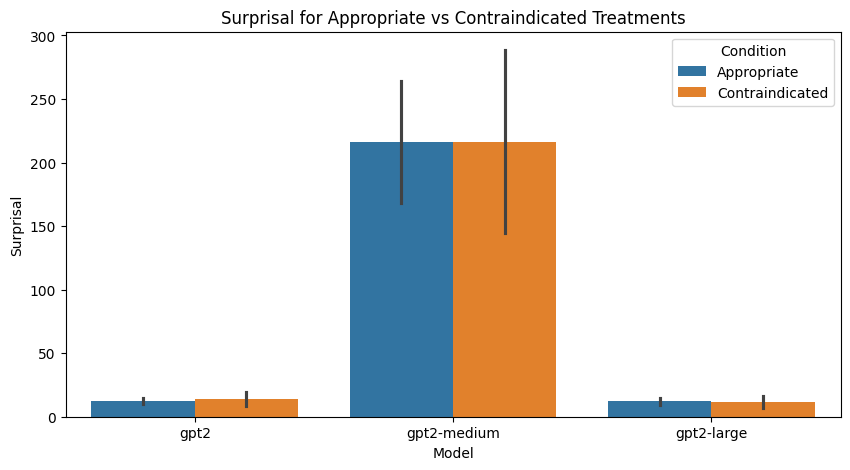

In [13]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_results, x="Model", y="Surprisal", hue="Condition")
plt.title("Surprisal for Appropriate vs Contraindicated Treatments")
plt.ylabel("Surprisal")
plt.show()

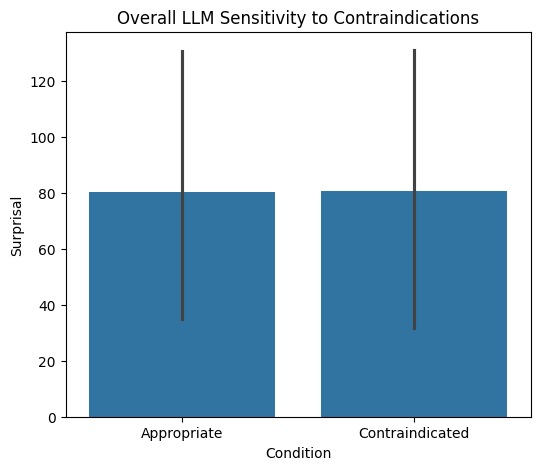

In [14]:
plt.figure(figsize=(6,5))
sns.barplot(data=df_results, x="Condition", y="Surprisal")
plt.title("Overall LLM Sensitivity to Contraindications")
plt.ylabel("Surprisal")
plt.show()

In [15]:
df_results.groupby("Condition")["Surprisal"].mean()

Condition
Appropriate        80.370845
Contraindicated    80.557164
Name: Surprisal, dtype: float64

In [16]:
# Paired comparison (same items)
appropriate = df_results[df_results["Condition"]=="Appropriate"]["Surprisal"]
contra = df_results[df_results["Condition"]=="Contraindicated"]["Surprisal"]

import scipy.stats as stats
stats.ttest_rel(contra[:len(appropriate)], appropriate)

TtestResult(statistic=np.float64(0.01586711447361008), pvalue=np.float64(0.9875251392635853), df=np.int64(17))

In [ ]:
#This means there is no statistically significant difference between surprisal for appropriate vs. contraindicated completions

In [ ]:
#A t-value close to 0 means the difference between the two conditions is essentially zero.